In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import zipfile


zip_path = '/content/drive/My Drive/clocks_dataset.zip'
extract_path = '/content/clocks_dataset/train/train'

os.makedirs(extract_path, exist_ok=True)


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [7]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from PIL import Image
from torch import tensor






Dataset from torch.utils is used to represent the dataset, we inherit it to define the clocks dataset, the constructer __init__ takes the directory which contains the data, and also the transformation that are applied to the data, image_files is initialized as an array of file paths in the directory that was inputted where these file paths ends with the extension of (.png) which represents the images extensions.
__len__ method returns the number of clocks images in the dataset.
method
getitem method takes an index as input, it extracts the path of image requested, and uses PIL.Image module to use this path to load the image, also a label path is constructed by replacing the extension of the image path with (.txt) to get the label of the corresponding image, the file from the label path is read and hours and minutes are extracted speratly by spliting them by (:), then it creates a tensor from the hour and minutes values extracted.
If any transformation operations were provided, the images are transformed by it. , then it returns the image and the tensor of the labels.

In [8]:
class ClockDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        # Correctly name the attribute
        self.image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]  # Use the correct attribute name here
        label_path = img_path.replace('.png', '.txt')

        # Load image
        image = Image.open(img_path)

        # Load label
        with open(label_path, 'r') as file:
            label = file.readline().strip()
            hour, minute = map(int, label.split(':'))

        labels_tensor = tensor([hour, minute])

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, labels_tensor

First a sequence of transformations to be applied to the pictures is defined, the images are resizeed from dimensions (448,448) into (64,64), this is done because this big dimension is not really needed, because at the end the aim of the model is to learn the angle in which leads to every hour and minute, so to keep our network small and weights small, it was resized like that. then ToTensor transformation is used to first scale the pixel values into the range of 0 to 1, and then convert the images into tensors. ColorJitter transformation was also used to randomly change the brightness, contrast, saturation, and hue of the images to increase the generalising ability of the model and to help to fight overfitting. As we are working on a clock dataset, transformation such as random rotation or random horizontal flip wasnt used as it didnt make sense because the angles will be corrupted making it dont correspond to the label.

The dataset is initialized with the directory path and the transformations. Then random_split function was used to split the dataset into training, validation and testing sets. 5% of the data is used for training, 15% for validation, and the remainder for testing, these values are a very common split.


In [43]:
transform = transforms.Compose([


    transforms.Resize((64,64)),
    transforms.ToTensor(),
    # transforms.Normalize([0.3401, 0.3411, 0.3410], [0.2669, 0.2692, 0.2676]),
    # transforms.RandomRotation(degrees=(-10, 10))
    # transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.4, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.RandomResizedCrop(size=32, scale=(0.2, 1.0), ratio=(1.0, 1.0))



])

clock_dataset = ClockDataset(directory=extract_path, transform=transform)

total_no = len(clock_dataset)
train_size = int(0.75 * total_no)
val_size = int(0.15 * total_no)
test_size = total_no - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(clock_dataset, [train_size, val_size, test_size])
print(len(train_dataset), len(val_dataset),len(test_dataset))


7500 1500 1000


Dataloader for training, validation and testing are set up using Dataloader class.

In [44]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True, num_workers=1)



In [45]:
image,labels =train_dataset[0]
print(image.shape)

torch.Size([3, 64, 64])


In [46]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([100, 3, 64, 64])
torch.Size([100, 2])


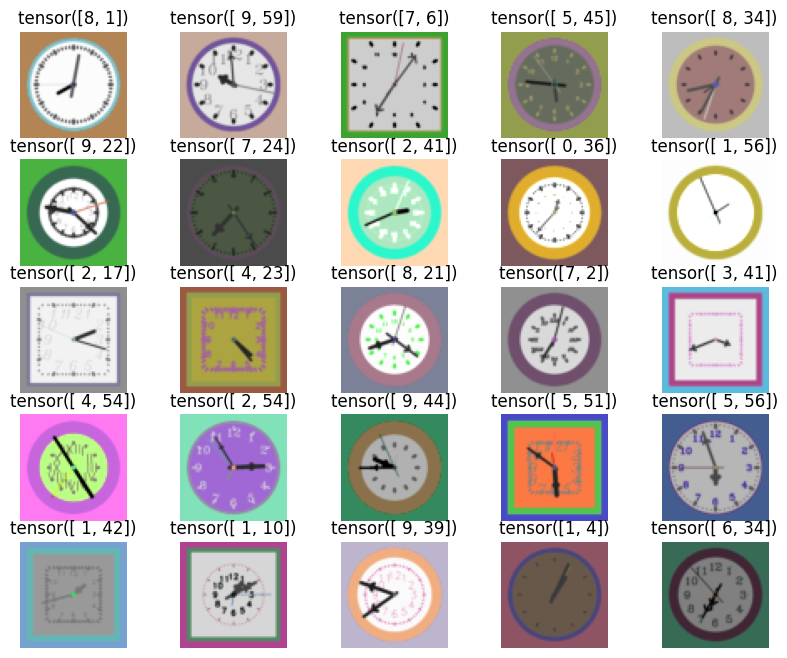

In [47]:
images, labels = next(iter(train_loader))

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    # img = images[i].permute(1, 2, 0)  # Reorder dimensions for displaying
    # img = img.clamp(0, 1)  # Clamp to make the img range [0, 1]
    figure.add_subplot(rows, cols, i+1)
    plt.title(labels[i])
    plt.axis("off")
    plt.imshow(images[i].permute(1, 2, 0))
plt.show()

A CNN is constructed, it is made up of 4 convolutional layers, convolutional layers are crucial to extract spatial features from every image, each layer is followed by a batch normalization to normalize the outputs of the layer to get better convergance, a ReLU function to introduce non linearity to allow the network to capture complicated patterns, a max pooling to reduce the spatial dimensions of the feature maps in order to make them invariant.
After the last covolutional layer, a dropout layer is used to prevent overfitting by dropping random units when training. Dropout is used after the batchnorm as according to academic papers, using dropout before batchnorm may lead into a problem called variance shift.

After the convolutional layers, the network is flattened and given as an input to a series of fully connected layers. they are used to reduce dimensionality to focus on the most effective features.

two output layers are used, one for the hours that acts as the prediction of the hours, it has output size of 12 which correspond for the hours on the clock. the second one is for the minutes which have output size of 60 that correspond the number of minutes in an hour.

As this is treated as classification problem, cross entropy loss was used as a loss function as it is the most common loss function used for classification, it measures the difference between the predicted probability distribution and the actual probability distribution.

This problem was treated as a classification because of the problem nature, both predicted variables are discrete and finite, this limited space makes it easier and suitable to be treated as a classification problem more of a regression problem.

In [61]:
class CNN(nn.Module):
  def __init__(self):

    super(CNN, self).__init__()

    self.convlayers = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels=32, kernel_size = 3, stride =1, padding =1),
        # B x 32 x 64 x 64
        nn.BatchNorm2d(32),
        # B x 32 x 64 x 64
        nn.ReLU(),
        # B x 32 x 64 x 64
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        # B x 32 x 32 x 32
        nn.Conv2d(in_channels = 32, out_channels=64, kernel_size = 3, stride =1, padding =1),
        # B x 64 x 32 x 32
        nn.BatchNorm2d(64),
        # B x 64 x 32 x 32
        nn.ReLU(),
        # B x 64 x 32 x 32
        nn.MaxPool2d(kernel_size=2,stride =2),
        # B x 64 x 16 x 16
        nn.Conv2d(in_channels = 64, out_channels = 128,kernel_size = 3,stride =1 , padding =1),
        # B x 128 x 16 x 16
        nn.BatchNorm2d(128),
        # B x 128 x 16 x 16
        nn.ReLU(),
        # B x 128 x 16 x 16
        nn.MaxPool2d(kernel_size=2,stride =2),
      # B x 128 x 8 x 8
        nn.Conv2d(in_channels = 128, out_channels = 256,kernel_size = 3,stride =1 , padding =1),
        # B x 256 x 8 x 8
        nn.BatchNorm2d(256),
        # B x 256 x 8 x 8
        nn.ReLU(),
        # B x 256 x 8 x 8
        nn.MaxPool2d(kernel_size=2,stride =2),
        # B x 256 x 4 x 4
        nn.Dropout(0.75)


    )

    self.fc1 = nn.Linear(in_features = 4 * 4 * 256, out_features = 1024)

    self.batch1 = nn.BatchNorm1d(1024)

    self.relu =  nn.ReLU()

    self.fc2 =  nn.Linear(in_features = 1024, out_features = 512)

    self.batch2 = nn.BatchNorm1d(512)

    self.dropout2 = nn.Dropout(0.25)

    self.fcHours = nn.Linear(in_features = 512, out_features= 12)

    self.fcMins = nn.Linear(in_features = 512, out_features = 60)

  def forward(self,x):

    x= self.convlayers(x)

    x = x.view(x.size(0), -1)

    x = self.fc1(x)

    x = self.batch1(x)

    x = self.relu(x)

    x = self.fc2(x)

    x = self.batch2(x)

    x = self.relu(x)

    x = self.dropout2(x)

    hours = self.fcHours(x)
    mins = self.fcMins(x)

    return hours, mins

model = CNN()
loss_func = nn.CrossEntropyLoss()




In [54]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)


5149512


In [50]:
images, labels = next(iter(train_loader))
hours_label, minute_label = labels[:, 0], labels[:, 1]
hour_output, minute_output = model(images)
print(hour_output.shape,minute_output.shape)
hours_loss = loss_func(hour_output,hours_label)
minutes_loss = loss_func(minute_output,minute_label)
print(labels.size(0))
print(hours_loss,minutes_loss)

torch.Size([100, 12]) torch.Size([100, 60])
100
tensor(2.6472, grad_fn=<NllLossBackward0>) tensor(4.1384, grad_fn=<NllLossBackward0>)


This is our training and validation loop. first we check if A GPU is available to be used, if yes then the model is used to be used with GPU. number of epochs is set to 55 as this balances between exploration but not to lead into overfitting which will result in the model memorizing the data not learning it. the optimizer was set as the Adam optimizer as it is the most commonly used in image classification, it also builds on the methodologies of momentum and RSMP which makes it take the best aspects of both and combine them to result in the adaptive learning rate optimization. For the training loop, we loop over the number of epochs specified earlier. we then have an inner loop with the images and labels from the train loader and we load them. the model predicts the current batch of images, the prediction is made up of 2 parts, hours prediction and minutes prediction. seperate losses for minutes and hours are calculated using the loss function. the loss values of both is then summed, and gradients are cleared before computing the gradients of the total loss,  then the parameters are updated based on these gradients. then the predictions of minutes and hours are extracted by selecting the class with highest probability, they are compared to the actual labels. each epoch the training loss and accuracy is recorded.

for validation, the model is switched to evaluation mode, with no gradients being computed, the validation process is similar to the training process but with no parameters are updated as we want to evaluate the model peformance on unseen data. and after each epoch the validation loss and accuracy is recorded and updated.

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

num_epochs = 55

optim = torch.optim.Adam(model.parameters(), lr = 0.01)
iterations_per_epoch = math.ceil(len(train_dataset)/100)
train_losses= []
val_losses = []
training_accuracies=[]
val_accuracies = []

for epoch in range(num_epochs):
  total_loss = 0
  correct = 0
  total = 0
  for images , labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    hours_label, minute_label = labels[:, 0], labels[:, 1]
    hour_output,mins_output = model(images)
    loss_hour = loss_func(hour_output,hours_label)
    loss_mins = loss_func(mins_output,minute_label)
    loss = loss_hour + loss_mins
    optim.zero_grad()
    loss.backward()
    optim.step()
    pred_hours = torch.argmax(hour_output, 1)
    pred_mins = torch.argmax(mins_output, 1)
    correct += ((pred_hours == hours_label) & (pred_mins == minute_label)).sum()
    total += float(labels.size(0))
    total_loss += loss*images.shape[0]
    if (i+1) % 100 == 0:
       print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()))

  train_losses.append(total_loss / len(train_dataset))
  training_accuracies.append((correct/total).cpu())
  print('Train accuracy over epoch {}: {:.4f}'.format(epoch+1,training_accuracies[-1]))

  correct = 0
  total = 0
  total_val_loss = 0
  model.eval()
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      hours_label, minute_label = labels[:, 0], labels[:, 1]
      hour_output,mins_output = model(images)
      loss_hour = loss_func(hour_output,hours_label)
      loss_mins = loss_func(mins_output,minute_label)
      loss = loss_hour + loss_mins
      pred_hours = torch.argmax(hour_output, 1)
      pred_mins = torch.argmax(mins_output, 1)
      correct += ((pred_hours == hours_label) & (pred_mins == minute_label)).sum()
      total += float(labels.size(0))
      total_val_loss += loss*images.shape[0]
    val_accuracy = correct/total
  total_val_loss  /= len(val_dataset)
  val_losses.append(total_val_loss.item())
  model.train()
  val_accuracies.append(val_accuracy.cpu())
  print('val accuracy at epoch {}: {:.4f}'.format(epoch+1,val_accuracy),"\n")




cuda
Train accuracy over epoch 1: 0.0015
val accuracy at epoch 1: 0.0013 

Train accuracy over epoch 2: 0.0019
val accuracy at epoch 2: 0.0013 

Train accuracy over epoch 3: 0.0020
val accuracy at epoch 3: 0.0027 

Train accuracy over epoch 4: 0.0039
val accuracy at epoch 4: 0.0080 

Train accuracy over epoch 5: 0.0183
val accuracy at epoch 5: 0.0333 

Train accuracy over epoch 6: 0.0407
val accuracy at epoch 6: 0.0727 

Train accuracy over epoch 7: 0.0911
val accuracy at epoch 7: 0.1347 

Train accuracy over epoch 8: 0.1524
val accuracy at epoch 8: 0.2087 

Train accuracy over epoch 9: 0.2016
val accuracy at epoch 9: 0.2487 

Train accuracy over epoch 10: 0.2452
val accuracy at epoch 10: 0.2773 

Train accuracy over epoch 11: 0.2947
val accuracy at epoch 11: 0.3560 

Train accuracy over epoch 12: 0.3265
val accuracy at epoch 12: 0.3987 

Train accuracy over epoch 13: 0.3673
val accuracy at epoch 13: 0.4420 

Train accuracy over epoch 14: 0.4044
val accuracy at epoch 14: 0.4120 

Train

the training and validation losses curves are plotted, and also the classification accuracy is printed across epochs for training and validation. the loss and accuracy are converted from pytorch tensors into numpy arrays as matplotlib dont work with pytorch tensors, they cant be printed in this format. the training loss and classification accuracy is plotted in a red color, the validation loss and classification accuracy is plotten in the green color. the plot shows that there is a generalization error, it is shown in both loss and classification plots, but it is seen that its not great which can indicate that our model dont go to overfitting, this is because of our choice of hyperparameters that balance between the power of the model and complexity, makint the model have the power to be capable to capture non linear relationships and patters, but without making it too complicated to lead into overfitting of the data that leads to memorizing the data rather than learning it. This generalization error shows that the training set didnt represent all the patterns that where shown in the validation set. The overfitting was tried to be fought by using batch normalization and dropout layers, which lead to not so much overfitting but still the model architecture and hyperparameters lead to this generalization error, however it is reasonably and can be seen as controlled. as seen, towards reaching the last epochs, the curves can be seen as reaching a plateau which justifies the number of epochs set that allow to model to effectivly capture and learn the patterns but without resulting in extreme overfitting. the near smoothiness of both curves shows that learning rate result in fast learning without causing instability.

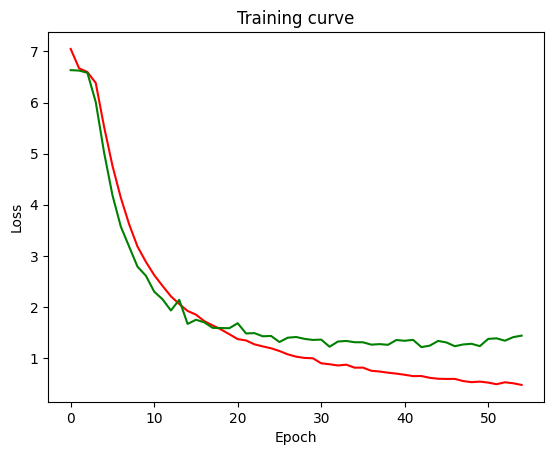

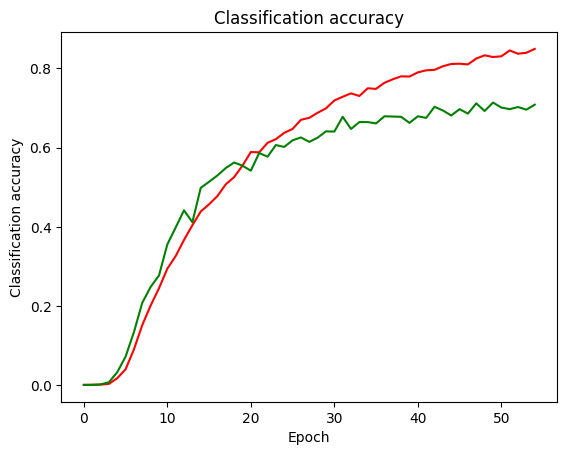

In [63]:
plt.title("Training curve")
plt.plot(range(len(train_losses)), [x.cpu().detach().numpy() if isinstance(x, torch.Tensor) else x for x in train_losses], 'r')
plt.plot(range(len(val_losses)), [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in val_losses], 'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.title("Classification accuracy")
plt.plot(range(len(training_accuracies)), [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in training_accuracies], 'r')
plt.plot(range(len(val_accuracies)), [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in val_accuracies], 'g')
plt.xlabel("Epoch")
plt.ylabel("Classification accuracy")
plt.show()

In [64]:
import numpy as np


def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    total_differences = []

    with torch.no_grad():  # No need to track gradients
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            hours_pred, mins_pred = model(images)
            hours_pred = torch.argmax(hours_pred, dim=1)
            mins_pred = torch.argmax(mins_pred, dim=1)

            # Convert predictions to total minutes
            total_minutes_pred = hours_pred * 60 + mins_pred

            # Convert ground truth to total minutes
            hours_true = labels[:, 0]
            mins_true = labels[:, 1]
            total_minutes_true = hours_true * 60 + mins_true

            # Calculate absolute differences
            differences = torch.abs(total_minutes_pred - total_minutes_true)
            total_differences.extend(differences.cpu().numpy())  # Store differences

    # Calculate median of the absolute differences
    median_difference = np.median(total_differences)
    print(total_differences)
    return median_difference

# Evaluate the model
median_error = evaluate_model(model, test_loader)
print(f"The median absolute error in minutes is: {median_error}")

[0, 0, 44, 0, 1, 0, 0, 0, 33, 0, 0, 0, 120, 1, 0, 0, 0, 9, 0, 0, 16, 0, 0, 60, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 29, 0, 0, 341, 0, 0, 0, 480, 0, 1, 0, 0, 0, 0, 4, 1, 0, 0, 32, 1, 374, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 278, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 174, 0, 0, 0, 1, 0, 12, 0, 1, 30, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 1, 13, 0, 0, 70, 0, 1, 1, 1, 0, 0, 0, 0, 12, 0, 55, 0, 0, 0, 1, 0, 1, 540, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 26, 0, 0, 1, 582, 712, 0, 0, 0, 240, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 277, 0, 69, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 61, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 360, 60, 0, 60, 0, 0, 0, 1, 1, 6, 120, 5, 0, 0, 0, 1, 1, 568, 1, 60, 0, 14, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 49, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 60, 0, 0, 160, 1, 0, 0, 0, 0, 0, 23, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

In [65]:
torch.save(model.state_dict(), 'model_weights2.pth')

In [66]:
def get_file_size(file_path):
    size_bytes = os.path.getsize(file_path)
    size_mib = size_bytes / (1024 * 1024)
    return size_mib

# Check the size of the saved model weights
weights_size = get_file_size('model_weights2.pth')
print(f"Model weights size: {weights_size:.2f} MiB")

Model weights size: 19.67 MiB
